# Correlation function 

In this tutorial we will compute coherence function for NV Center in diamond and then reproduce it from the correlation function of the noise

The correlation function $C(t)$ of the effective magnetic field (noise) along $z$-axis can be defined as following:

\begin{equation}
    C(t) = \left\langle \beta_z(t)\beta_z(0) \right\rangle
\end{equation}

With $\beta_z$ given as:

\begin{equation}
    \beta_z(t) = U^{\dagger}(t) \left( \sum_{\{I\}}{A_{zz} I_z} \right) U(t)
\end{equation}

Where $U(t)$ is time propagator.

The correlation function in CCE formalizm is computed as:

\begin{equation}
    C(t) = \sum_{\{i\}} {\tilde C_{\{i\}}(t)} + \sum_{\{ij\}} {\tilde C_{\{ij\}}(t)}\ + \ ...
\end{equation}

With contributions computed as:

\begin{equation}
    \tilde C_{\nu}(t) = C_{\nu}(t) - \sum_{\nu'  \subset\ \nu} {\tilde C_{\nu'}(t)}
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('/home/onizhuk/midway/codes_development/pyCCE')
import pycce as pc

# Install a pip package in the current Jupyter kernel
# !{sys.executable} -m pip install --user ase
# !{sys.executable} -m pip install --user numpy --upgrade

import ase

seed = 42055
np.set_printoptions(suppress=True, precision=5)

## Generate nuclear spin bath
Building a `BathArray` of nuclear spins from the `ase.Atoms` object.

In [2]:
from ase.build import bulk

# Generate unitcell from ase
diamond = bulk('C', 'diamond', cubic=True)
diamond = pc.bath.BathCell.from_ase(diamond)
# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))
# set z direction of the defect
diamond.zdir = [1, 1, 1]
# Add the defect. remove and add atoms at the positions (in cell coordinates)
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]),
                              seed=seed)

Next, we define all of the parameters of the simulation. We are interested in the very specific regime, when all nearby nuclear spins are removed. To achieve this goal we define an `inner = 20` parameter, and remove all nuclear spins within this radius.

In [3]:
position = np.array([0, 0, 0])
inner = 20
smallatoms = atoms[atoms.dist(position) >= inner]

parameters = dict(
    order=2, # CCE order
    r_bath=60,  # Size of the bath in A
    r_dipole=6,  # Cutoff of pairwise clusters in A
    position=position, # Position of central Spin
    alpha=[0, 0, 1],
    beta=[0, 1, 0]
) # Qubit levels

ts = np.linspace(0, 2.5, 1001)  # Time points in ms
N = 1 # N pulses in CPMG sequence
B = np.array([0, 0, 500])  # Magnetic field in G

## Coherence calculations
Next, we set up `Simulator` objects and check convergence with respect to CCE order

In [4]:
calc = pc.Simulator(spin=1, bath=smallatoms, **parameters)

In [5]:
orders = [2, 3, 4]
coh = {}
for o in orders: 
    calc.generate_clusters(o)
    coh[o] = calc.compute(ts, B, N, method='cce', quantity='coherence', as_delay=False)
coh = np.abs(pd.DataFrame(coh, index=ts))
coh.index.name = 'Time (ms)'

Visually check the convergence

Text(0, 0.5, 'Coherence')

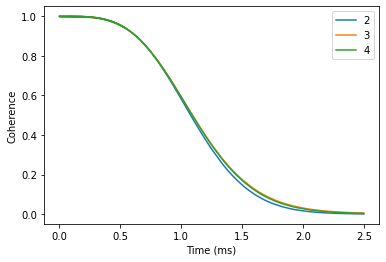

In [6]:
coh.plot()
plt.ylabel('Coherence')

## Noise calculations
To compute correlation function of the noise, we call `Simulator.compute` method and specify `quantity = 'noise'`. First we determine convergence with the order

Text(0, 0.5, 'Correlation')

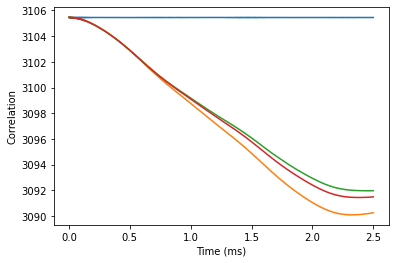

In [7]:
for o in [1, 2, 3, 4]:
    calc.generate_clusters(o)
    noise = calc.compute(ts, B, method='cce', quantity='noise')
    plt.plot(ts, noise.real)
plt.xlabel('Time (ms)')
plt.ylabel('Correlation')

The difference between third and fourth order is fairly small, we will use the fourth order for the following calculations.

In [8]:
calc.generate_clusters(4)

noise = calc.compute(ts, B, method='cce', quantity='noise')
gennoise = calc.compute(ts, B, method='gcce', quantity='noise', mean_field=False)

Compare the results obtained with CCE and gCCE approaches. Note that they are slighlity different. However, as we will see it does not impact the predicted coherence.

Text(0, 0.5, 'Correlation')

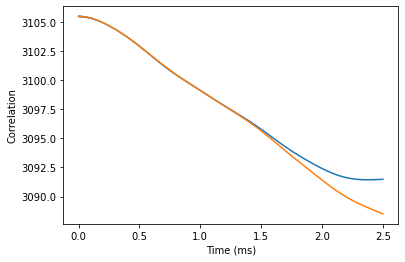

In [9]:
plt.plot(ts, noise.real, label='CCE')
plt.plot(ts, gennoise.real, label='gCCE')
plt.xlabel('Time (ms)')
plt.ylabel('Correlation')

Assuming that the noise is Gaussian, we can reproduce the coherence from the average phase squared $\langle\phi^2\rangle$, accumulated by the spin qubit:

\begin{equation}
   L(t)=e^{-\langle \phi^2(t) \rangle}
\end{equation}

The average phase is obtained from the autocorrelation function as:

\begin{equation}
   \langle \phi^2(t) \rangle = \int_0^t{d\tau C(\tau) F(\tau)}
\end{equation}

Where $F(\tau)$ is the correlation filter function (see [Phys. Rev. A 86, 012314 (2012)](https://doi.org/10.1103/PhysRevA.86.012314) for details).

PyCCE code already has implemented calculations of the phase in the `pycce.filter` module:

`pycce.filter.gaussian_phase` takes three positional arguments:
- `timespace` - time points at which correlation function was computed
- `corr` - noise autocorrelation function
- `npulses` - number of pulses in CPMG sequence

Here we compute phase for the Hahn-echo experiment. Note that the implementation of `gaussian_phase` is not heavily optimized and can take a hot second.

In [10]:
import pycce.filter

chis =  pycce.filter.gaussian_phase(ts, np.abs(noise), 1)
gchis = pycce.filter.gaussian_phase(ts, np.abs(gennoise), 1)

Now compare results from direct calculations of the coherence function, and the one reconstructed from the noise autocorrelation:

Text(0, 0.5, 'L')

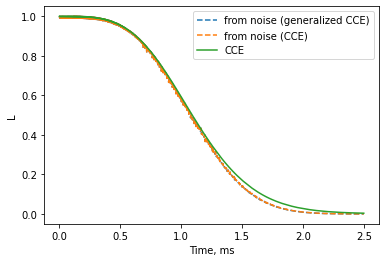

In [11]:
plt.plot(ts, np.exp(-gchis), ls='--', marker='', label='from noise (generalized CCE)')
plt.plot(ts, np.exp(-chis), ls='--', label='from noise (CCE)')
plt.plot(ts, coh[4], label='CCE')
plt.legend()
plt.xlabel('Time, ms')
plt.ylabel('L')